## Import Libraries

In [1]:
from pyspark.sql import SparkSession, Row
from pyspark.sql.window import Window
from pyspark.sql.functions import *
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType

spark = SparkSession.builder.appName("FinalProject").getOrCreate()

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1749162119207_0001,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Installing Needed Libraries

In [4]:
sc.install_pypi_package("boto3")
sc.install_pypi_package("pandas")
import boto3
import pandas as pd

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
Package already installed for current Spark context!
Traceback (most recent call last):
  File "/mnt/yarn/usercache/livy/appcache/application_1749162119207_0001/container_1749162119207_0001_01_000001/pyspark.zip/pyspark/context.py", line 2614, in install_pypi_package
    raise ValueError("Package already installed for current Spark context!")
ValueError: Package already installed for current Spark context!



Now that we loaded our Preprocessing libraries we can load our data. I created my bucket ahead of time and uploaded my data into it.

In [5]:
songs_raw = spark.read.csv(
    "s3://final-project-spotify-bucket/spotify_dataset.csv",
    header=True,
    inferSchema=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Now that we loaded our raw data, we may drop columns that I wont be using for our predictions. I decided my prediction variables to be 'Tempo', 'Loudness (db)','Length', 'Explicit', 'Energy', 'Danceability', 'Positiveness', 'Speechiness', 'Liveness', 'Acousticness', 'Instrumentalness', 'Good for Party', 'Good for Work/Study', 'Good for Relaxation/Meditation', 'Good for Exercise', 'Good for Running', 'Good for Yoga/Stretching', 'Good for Driving', 'Good for Social Gatherings', 'Good for Morning Routine' Therefore we will drop the remainder.

Our target variable is Popularity

In [6]:
columns_to_drop = [
    "Artist(s)", "song", "text", "Length", "emotion", "Genre", "Album",
    "Release Date", "Key", "Time signature", "Similar Artist 1",
    "Similar Song 1", "Similarity Score 1", "Similar Artist 2",
    "Similar Song 2", "Similarity Score 2", "Similar Artist 3",
    "Similar Song 3", "Similarity Score 3"
]
songsCleaned = songs_raw.drop(*columns_to_drop)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Checking if we are left only with the desiriable columns

In [7]:
print(songsCleaned.columns)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['Tempo', 'Loudness (db)', 'Explicit', 'Popularity', 'Energy', 'Danceability', 'Positiveness', 'Speechiness', 'Liveness', 'Acousticness', 'Instrumentalness', 'Good for Party', 'Good for Work/Study', 'Good for Relaxation/Meditation', 'Good for Exercise', 'Good for Running', 'Good for Yoga/Stretching', 'Good for Driving', 'Good for Social Gatherings', 'Good for Morning Routine']

Here we turn all of our booleans in the dataset to ones and 0s (This also worked on yes and no's which is not a bug but a feature since we would have to transform those as well)

In [8]:
bool_cols = [
    "Explicit", "Good for Party", "Good for Work/Study",
    "Good for Relaxation/Meditation", "Good for Exercise", "Good for Running",
    "Good for Yoga/Stretching", "Good for Driving",
    "Good for Social Gatherings", "Good for Morning Routine"
]

for c in bool_cols:
    songsCleaned = songsCleaned.withColumn(c,
                                           when(col(c) == True, 1).otherwise(0))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Dropping all the rows that are have any data null 

In [9]:
songsCleaned = songsCleaned.dropna()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Turning the all the columns to an int/float (making sure there are no numbers that are strings also removing db from Loudness column)

In [10]:
songsCleaned = songsCleaned.withColumn(
    "Loudness (db)", regexp_replace(col("Loudness (db)"), "db", ""))
songsCleaned = songsCleaned.withColumn("Loudness (db)",
                                       trim(col("Loudness (db)")))

# List all columns
columns_to_cast = [c for c in songsCleaned.columns]

for c in columns_to_cast:
    if c == "Loudness (db)":
        songsCleaned = songsCleaned.withColumn(c, col(c).cast("float"))
    else:
        songsCleaned = songsCleaned.withColumn(c, col(c).cast("int"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Dropping faulty data which could not be cast into an int or a float


In [11]:
songsCleaned = songsCleaned.dropna()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

After making all rows consistent we can check for duplicates (In the previous versions I did it with unformated data and got unexpected behavior)

In [12]:
total_rows = songsCleaned.count()
distinct_rows = songsCleaned.distinct().count()

print(f"Total rows: {total_rows}")
print(f"Distinct rows: {distinct_rows}")
print(f"Duplicates found: {total_rows - distinct_rows}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total rows: 460654
Distinct rows: 387961
Duplicates found: 72693

Removing Duplicates to prevent overfitting from repeated records

In [13]:
songsCleaned = songsCleaned.distinct()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Optional test to see if it worked

In [12]:
total_rows = songsCleaned.count()
distinct_rows = songsCleaned.distinct().count()

print(f"Total rows: {total_rows}")
print(f"Distinct rows: {distinct_rows}")
print(f"Duplicates found: {total_rows - distinct_rows}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total rows: 387961
Distinct rows: 387961
Duplicates found: 0

Now that we cleaned and prepared our data we can save it in our bucket so we can query it with Athena and make it Machine Learning ready

In [13]:
songsCleaned.write.mode("overwrite").option(
    "header",
    "false").csv("s3://final-project-spotify-bucket/clean_song_dataset")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Setting up Athena to query our data efficiently and Transform it to be Machine Learning Ready

Setting up Athena Variables (I know i should load my access keys from a json file since this is a security risk but since this is temporary and get generated every time I think it is ok(hopefully i remember this when Im on the job))

In [ ]:
DATABASE_NAME = 'michalfinalfroject'
TABLE_NAME = 'cleanedSongs'
AWS_REGION = 'us-east-1'
S3_DATA_PATH = 's3://final-project-spotify-bucket/clean_song_dataset/'
aws_access_key_id = ''
aws_secret_access_key = ''
aws_session_token = ''
s3_output = 's3://final-project-spotify-bucket//athena-results/'

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Starting Athena Client

In [15]:
athena_client = boto3.client('athena',
                             region_name=AWS_REGION,
                             aws_access_key_id=aws_access_key_id,
                             aws_secret_access_key=aws_secret_access_key,
                             aws_session_token=aws_session_token)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Making sure athena is wiped clean before using it

In [16]:
query = f"DROP TABLE IF EXISTS {DATABASE_NAME}.{TABLE_NAME};"
athena_client.start_query_execution(
    QueryString=query,
    QueryExecutionContext={'Database': DATABASE_NAME},
    ResultConfiguration={'OutputLocation': s3_output})

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{'QueryExecutionId': '261567b3-345d-48f9-9be9-71d275c4e5d4', 'ResponseMetadata': {'RequestId': '98119922-c047-4fce-a838-c4901cf9727b', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Thu, 05 Jun 2025 22:30:18 GMT', 'content-type': 'application/x-amz-json-1.1', 'content-length': '59', 'connection': 'keep-alive', 'x-amzn-requestid': '98119922-c047-4fce-a838-c4901cf9727b'}, 'RetryAttempts': 0}}

Creating Athena Database

In [17]:
create_db_query = f"CREATE DATABASE IF NOT EXISTS {DATABASE_NAME}"

# Start query execution
response = athena_client.start_query_execution(
    QueryString=create_db_query,
    ResultConfiguration={'OutputLocation': s3_output})

query_execution_id = response['QueryExecutionId']
print(f"Started database creation query with ID: {query_execution_id}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Started database creation query with ID: 679c4a8b-3072-4c88-83f2-f1e0289263bc

Creating Athena Table

In [18]:
create_table_query = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS `{DATABASE_NAME}`.`{TABLE_NAME}` (
    Tempo INT,
    `Loudness (db)` FLOAT,
    Explicit INT,
    Popularity INT,
    Energy INT,
    Danceability INT,
    Positiveness INT,
    Speechiness INT,
    Liveness INT,
    Acousticness INT,
    Instrumentalness INT,
    `Good for Party` INT,
    `Good for Work/Study` INT,
    `Good for Relaxation/Meditation` INT,
    `Good for Exercise` INT,
    `Good for Running` INT,
    `Good for Yoga/Stretching` INT,
    `Good for Driving` INT,
    `Good for Social Gatherings` INT,
    `Good for Morning Routine` INT
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LOCATION '{S3_DATA_PATH}'
"""
print(create_table_query.strip())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

CREATE EXTERNAL TABLE IF NOT EXISTS `michalfinalfroject`.`cleanedSongs` (
    Tempo INT,
    `Loudness (db)` FLOAT,
    Explicit INT,
    Popularity INT,
    Energy INT,
    Danceability INT,
    Positiveness INT,
    Speechiness INT,
    Liveness INT,
    Acousticness INT,
    Instrumentalness INT,
    `Good for Party` INT,
    `Good for Work/Study` INT,
    `Good for Relaxation/Meditation` INT,
    `Good for Exercise` INT,
    `Good for Running` INT,
    `Good for Yoga/Stretching` INT,
    `Good for Driving` INT,
    `Good for Social Gatherings` INT,
    `Good for Morning Routine` INT
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LOCATION 's3://final-project-spotify-bucket/clean_song_dataset/'

In [19]:
response = athena_client.start_query_execution(
    QueryString=create_table_query.strip(),
    QueryExecutionContext={'Database': DATABASE_NAME},
    ResultConfiguration={'OutputLocation': s3_output})

print("Athena table creation query submitted.")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Athena table creation query submitted.

Check if Athena will parse our database corectly

In [20]:
import time


# Function to run Athena query
def run_athena_query(query, database, output_location):
    response = athena_client.start_query_execution(
        QueryString=query,
        QueryExecutionContext={'Database': database},
        ResultConfiguration={'OutputLocation': output_location})
    return response['QueryExecutionId']


# Function to check query status
def check_query_status(query_execution_id):
    while True:
        response = athena_client.get_query_execution(
            QueryExecutionId=query_execution_id)
        status = response['QueryExecution']['Status']['State']
        if status == 'SUCCEEDED':
            print("Query succeeded!")
            break
        elif status in ['FAILED', 'CANCELLED']:
            print(f"Query {status.lower()}.")
            raise Exception(f"Query failed or was cancelled: {response}")
        time.sleep(2)


# Function to get query results and convert to pandas DataFrame
def get_query_results_as_dataframe(query_execution_id):
    # Fetching the query results
    results_paginator = athena_client.get_paginator('get_query_results')
    results_iter = results_paginator.paginate(
        QueryExecutionId=query_execution_id)

    # Initialize a list to store rows and columns for DataFrame
    columns = []
    rows = []

    # Process the result pages
    for results_page in results_iter:
        # Get column info from the first page
        if not columns:
            columns = [
                col['Label'] for col in results_page['ResultSet']
                ['ResultSetMetadata']['ColumnInfo']
            ]

        # Skip the first row of the first page (column headers)
        for row in results_page['ResultSet']['Rows'][1:]:
            rows.append([col.get('VarCharValue', None) for col in row['Data']])

    # Create DataFrame from the results
    df = pd.DataFrame(rows, columns=columns)
    return df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
# Query details
query = f'SELECT * FROM "{DATABASE_NAME}"."{TABLE_NAME}" limit 10;'
database = 'default'
output_location = s3_output

# Run the query
query_execution_id = run_athena_query(query, database, output_location)

# Check the status of the query
check_query_status(query_execution_id)

# Fetch the results as a pandas DataFrame
df = get_query_results_as_dataframe(query_execution_id)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Query succeeded!

Displaying first 10 records and 7 columns to see if looks ok using panda

In [22]:
df.iloc[:, :7]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  tempo loudness (db) explicit popularity energy danceability positiveness
0   106         -7.09        1         76     68           75           19
1    85         -6.93        0         28     45           47           30
2   155         -5.23        0         23     96           21           27
3   109        -18.96        0         20      6           47           32
4   114        -10.12        0         19     31           56           41
5   137         -5.88        0         56     68           84           92
6   113         -2.22        0         35     96           56           82
7   176        -12.78        0         21     46           38           55
8   196         -9.86        0         29     35           65           28
9   140         -6.22        0         23     58           65           25

Querying data to use with Spark

Re defining our headers for our spark dataframe queried from athena

In [23]:
schema = StructType([
    StructField("tempo", IntegerType(), False),
    StructField("loudness(db)", FloatType(), False),
    StructField("explicit", IntegerType(), False),
    StructField("popularity", IntegerType(), False),
    StructField("energy", IntegerType(), False),
    StructField("danceability", IntegerType(), False),
    StructField("positiveness", IntegerType(), False),
    StructField("speechiness", IntegerType(), False),
    StructField("liveness", IntegerType(), False),
    StructField("acousticness", IntegerType(), False),
    StructField("instrumentalness", IntegerType(), False),
    StructField("good for party", IntegerType(), False),
    StructField("good for work/study", IntegerType(), False),
    StructField("good for relaxation/meditation", IntegerType(), False),
    StructField("good for exercise", IntegerType(), False),
    StructField("good for running", IntegerType(), False),
    StructField("good for yoga/stretching", IntegerType(), False),
    StructField("good for driving", IntegerType(), False),
    StructField("good for social gatherings", IntegerType(), False),
    StructField("good for morning routine", IntegerType(), False)
])


def get_query_results_as_spark_dataframe(query_execution_id):
    results_paginator = athena_client.get_paginator('get_query_results')
    results_iter = results_paginator.paginate(
        QueryExecutionId=query_execution_id)

    data_rows = []

    for page_num, results_page in enumerate(results_iter):
        rows = results_page['ResultSet']['Rows']
        if page_num == 0:
            rows = rows[1:]  # skip header row

        for row in rows:
            values = [col.get('VarCharValue', None) for col in row['Data']]

            # Parse each value into appropriate types
            parsed_row = [
                int(values[0]),  # tempo
                float(values[1]),  # loudness(db)
                *map(int, values[2:])  # all remaining columns as int
            ]
            data_rows.append(parsed_row)

    # Create Spark DataFrame with defined schema
    spark_df = spark.createDataFrame(data_rows, schema=schema)
    return spark_df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
query = f'SELECT * FROM "{DATABASE_NAME}"."{TABLE_NAME}"'
database = 'default'
output_location = s3_output

# Run the query
query_execution_id = run_athena_query(query, database, output_location)

# Check the status of the query
check_query_status(query_execution_id)

spark_df = get_query_results_as_spark_dataframe(query_execution_id)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Query succeeded!

We have our data Queried from Athena so we can move on to the machine learning portion

Installing more libraries and importing more stuff for machine learning

In [25]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml.regression import *
from pyspark.ml.evaluation import RegressionEvaluator

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
sc.install_pypi_package("numpy")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
import numpy as np

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
input_columns = [
    'tempo', 'loudness(db)', 'explicit', 'energy', 'danceability',
    'positiveness', 'speechiness', 'liveness', 'acousticness',
    'instrumentalness', 'good for party', 'good for work/study',
    'good for relaxation/meditation', 'good for exercise', 'good for running',
    'good for yoga/stretching', 'good for driving',
    'good for social gatherings', 'good for morning routine'
]
dependent_var = 'popularity'

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Plotting Loudness histogram to show how our data is skewed

In [29]:
sc.install_pypi_package("python-dateutil==2.8.2")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.9.0.post0
    Uninstalling python-dateutil-2.9.0.post0:
      Successfully uninstalled python-dateutil-2.9.0.post0


In [30]:
sc.install_pypi_package("matplotlib")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [38]:
sample_df = spark_df.sample(withReplacement=False, fraction=0.02, seed=42)
sample_pd = sample_df.select("loudness(db)").toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [39]:
print(sample_pd)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

      loudness(db)
0           -12.86
1            -5.28
2           -13.00
3            -3.30
4            -7.92
...            ...
7811         -6.18
7812         -8.02
7813         -9.57
7814         -8.00
7815        -10.38

[7816 rows x 1 columns]

In [40]:

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(sample_pd['loudness(db)'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of loudness(db) Before Skewness Treatment')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

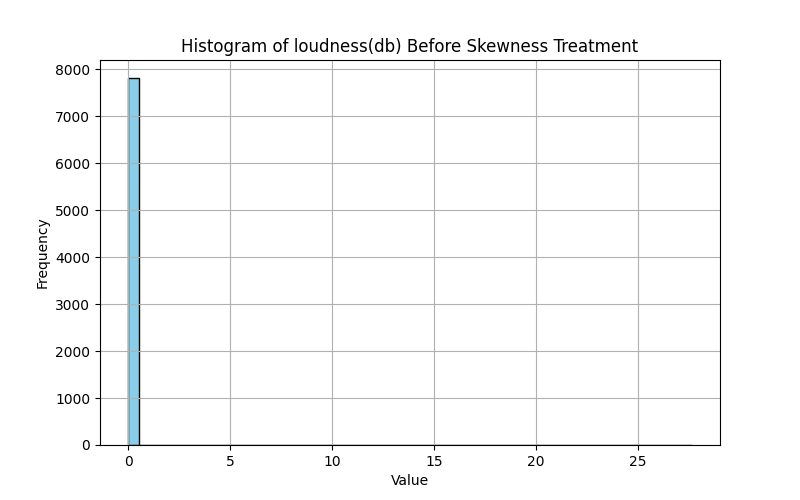

In [47]:
%matplot plt

Treating our data for Skewness (not including our booleans) 

In [48]:
skip_skew_cols = [
    "explicit", "good for party", "good for work/study",
    "good for relaxation/meditation", "good for exercise", "good for running",
    "good for yoga/stretching", "good for driving",
    "good for social gatherings", "good for morning routine"
]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
indexed = spark_df
quantiles = {}
for col_name in input_columns:
    if col_name not in skip_skew_cols:
        quantiles[col_name] = indexed.approxQuantile(col_name, [0.01, 0.99],
                                                     0.01)

for col_name in input_columns:
    if col_name in skip_skew_cols:
        continue

    skew_val = indexed.agg(skewness(col(col_name))).collect()[0][0]

    if skew_val is not None:
        if skew_val > 1:
            indexed = indexed.withColumn(
                col_name,
                log(
                    when(
                        col(col_name) < quantiles[col_name][0],
                        quantiles[col_name][0]).when(
                            col(col_name) > quantiles[col_name][1],
                            quantiles[col_name][1]).otherwise(col(col_name)) +
                    1))
            print(
                f"{col_name} has been treated for positive (right) skewness. (skew = {skew_val})"
            )

        elif skew_val < -1:
            indexed = indexed.withColumn(
                col_name,
                exp(
                    when(
                        col(col_name) < quantiles[col_name][0],
                        quantiles[col_name][0]).when(
                            col(col_name) > quantiles[col_name][1],
                            quantiles[col_name][1]).otherwise(col(col_name))))
            print(
                f"{col_name} has been treated for negative (left) skewness. (skew = {skew_val})"
            )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Assembling our vector

In [30]:
indexed = indexed.withColumnRenamed(dependent_var, 'label')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
assembler = VectorAssembler(inputCols=input_columns, outputCol='features')
final_data = assembler.transform(indexed).select('features', 'label')
final_data.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(19,[0,1,3,4,5,6,...|   33|
|(19,[0,1,3,4,5,6,...|   23|
|(19,[0,1,2,3,4,5,...|   21|
|(19,[0,1,3,4,5,6,...|   38|
|(19,[0,1,2,3,4,5,...|    7|
+--------------------+-----+
only showing top 5 rows

In [32]:
pearsonCorr = Correlation.corr(final_data, 'features',
                               'pearson').collect()[0][0]
corr_array = pearsonCorr.toArray()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Since the data wont display well here I will turn it into a spark dataframe and save it in my bucket so i can download it and check it locally and see which variables to remove

In [33]:
rows = [
    Row(**{input_columns[j]: float(row[j])
           for j in range(len(input_columns))})
    for row in corr_array
]

# Create Spark DataFrame from rows using input_columns as schema
spark_corr_df = spark.createDataFrame(rows, schema=input_columns)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [34]:
s3_path = "s3://final-project-spotify-bucket/clean_song_dataset/correlation_matrix.csv"  # Replace with your actual bucket path

spark_corr_df.coalesce(1).write.mode("overwrite").option("header",
                                                         True).csv(s3_path)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Using excel I figured out variables with high Multicollinearity which was (Good for relaxation) and (good for yoga/meditating) so I will drop the second one so I will drop them and rebuild my vector

In [35]:
indexed = indexed.drop('good for yoga/stretching')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [36]:
input_columns2 = [
    'tempo', 'loudness(db)', 'explicit', 'energy', 'danceability',
    'positiveness', 'speechiness', 'liveness', 'acousticness',
    'instrumentalness', 'good for party', 'good for work/study',
    'good for relaxation/meditation', 'good for exercise', 'good for running',
    'good for driving', 'good for social gatherings', 'good for morning routine'
]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
assembler = VectorAssembler(inputCols=input_columns2, outputCol='features')
final_data = assembler.transform(indexed).select('features', 'label')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Splitting our data for training

In [38]:
train, test = final_data.randomSplit([0.7, 0.3])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Fitting our regression model

In [39]:
regressor = LinearRegression()
fitModel = regressor.fit(train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Testing our Model

In [40]:
evaluator = RegressionEvaluator(metricName="rmse")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [41]:
# Make predictions.
predictions = fitModel.transform(test)
# Select (prediction, true label) and compute test error

rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Root Mean Squared Error (RMSE) on test data = 14.2141

In [42]:
regressor = LinearRegression()

#first without cross val
fitModel = regressor.fit(train)

# Load the Summary
trainingSummary = fitModel.summary

# Print the coefficients and intercept for linear regression
print('\033[1m' + "Linear Regression Model Summary without cross validation:" +
      '\033[0m')
print(" ")
print("Intercept: %s" % str(fitModel.intercept))
print("")
coeff_array = fitModel.coefficients.toArray()
coeff_scores = []
for x in coeff_array:
    coeff_scores.append(float(x))
# Then zip with input_columns list and create a df
result = spark.createDataFrame(zip(input_columns, coeff_scores),
                               schema=['feature', 'coeff'])
print(result.orderBy(result["coeff"].desc()).show(truncate=False))

# Summarize the model over the training set and print out some metrics
print("numIterations: %d" % trainingSummary.totalIterations)
print(
    "objectiveHistory: (scaled loss + regularization) at each iteration \n %s" %
    str(trainingSummary.objectiveHistory))
print("")

# Print the Errors
print("Training RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("Training r2: %f" % trainingSummary.r2)
print("")

# Now load the test results
test_results = fitModel.evaluate(test)

# And print them
print("Test RMSE: {}".format(test_results.rootMeanSquaredError))
print("Test r2: {}".format(test_results.r2))
print("")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Linear Regression Model Summary without cross validation:
 
Intercept: 27.575782508807418

+------------------------------+---------------------+
|feature                       |coeff                |
+------------------------------+---------------------+
|good for driving              |29.666214076263344   |
|good for party                |28.18559910845418    |
|good for relaxation/meditation|1.3198886031328785   |
|good for yoga/stretching      |0.6935701119473546   |
|good for work/study           |0.47610601130903546  |
|good for running              |0.32969355076645795  |
|energy                        |0.05915433185891517  |
|loudness(db)                  |0.055988691355818035 |
|danceability                  |0.05570647402422441  |
|tempo                         |0.011535394063802397 |
|positiveness                  |0.006337049917723758 |
|acousticness                  |-0.005491208502576184|
|instrumentalness              |-0.23340471402875856 |
|liveness                    